# Project

### Goal: Improve our original estimate of the log error by using clustering methodologies.

## Modeling

In [48]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Modeling
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None, 'display.max_rows', None)

import wrangle_zillow

zillow = pd.read_csv('zillow_fe.csv', index_col='Unnamed: 0')

Split your data into training and test sets.

In [42]:
train, test = wrangle_zillow.split_my_data(zillow, 0.8)

scaler, train, test = wrangle_zillow.min_max_scaler(train, test)

train, valid = wrangle_zillow.split_my_data(train, 0.8)

(26.0, 0.0)

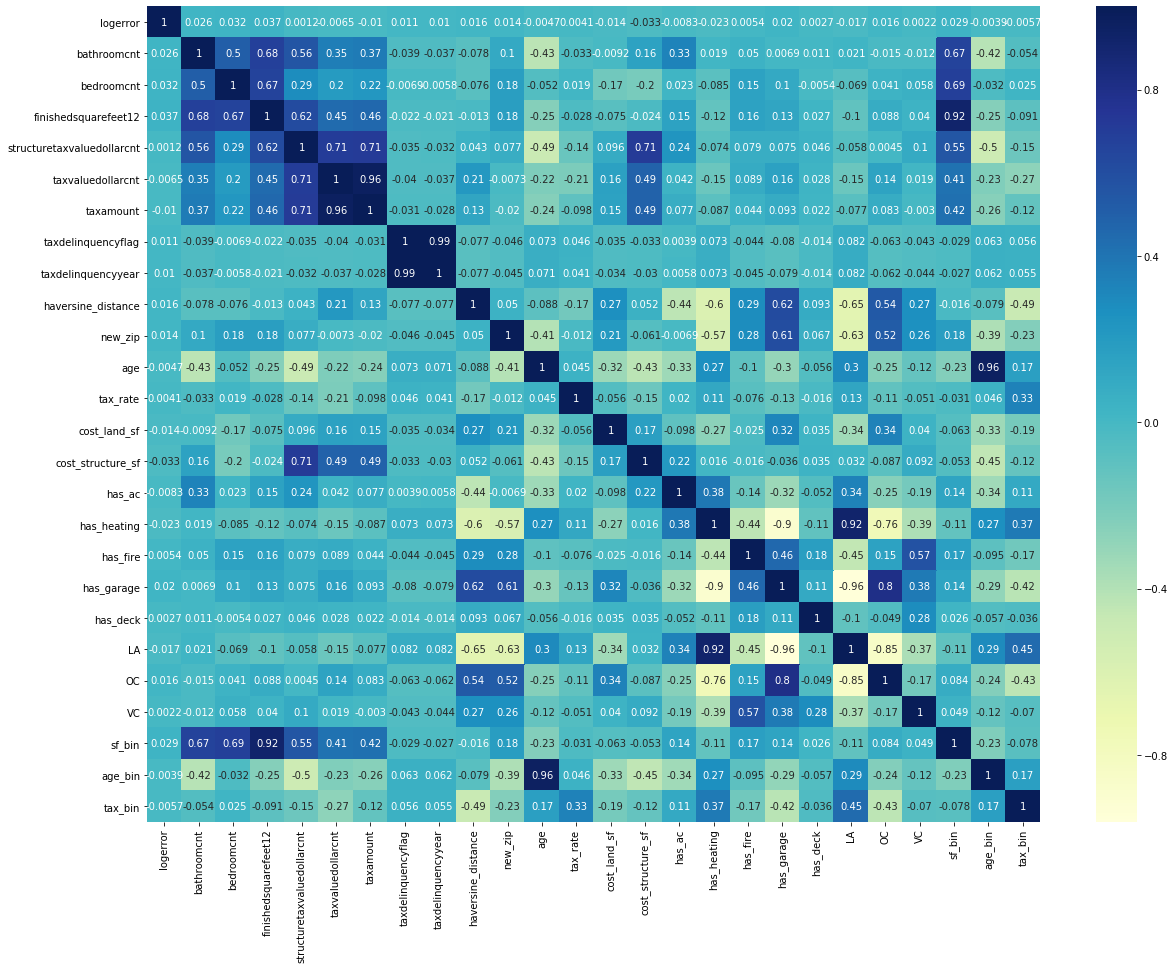

In [51]:
X = train[['logerror','bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12',
            'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount',
            'taxdelinquencyflag', 'taxdelinquencyyear', 'transactiondate',
            'haversine_distance', 'new_zip', 'median_income', 'age', 'tax_rate',
            'cost_land_sf', 'cost_structure_sf', 'has_ac', 'has_heating', 
            'has_fire', 'has_garage', 'has_deck', 'LA', 'OC', 'VC', 'sf_bin',
            'age_bin', 'tax_bin', 'cluster_fancy', 'cluster_lot']]

plt.figure(figsize=(20,15))
corr = X.corr()
ax = sns.heatmap(corr, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Create subsets of data if you would like to create multiple models and then merge (such as, a different model for each cluster or for each county).

In [43]:
train_LA = train[train.county == 'Los_Angeles']
train_OC = train[train.county == 'Orange']
train_VC = train[train.county == 'Ventura']

valid_LA = valid[valid.county == 'Los_Angeles']
valid_OC = valid[valid.county == 'Orange']
valid_VC = valid[valid.county == 'Ventura']

test_LA = test[test.county == 'Los_Angeles']
test_OC = test[test.county == 'Orange']
test_VC = test[test.county == 'Ventura']

## Model Selection

Train at least 3 different models (a model is different if there are changes in one or more of the following: features, hyper-parameters, algorithm). Create object, fit, predict & evaluate. Use mean absolute error or mean squared error to evaluate. Also, try regression algorithms you have not used before.

In [44]:
predictions_LA = pd.DataFrame({
    'actual': train_LA.logerror,
    'baseline': train_LA.logerror.mean()
})

In [46]:
# MVP model from before
X = train_LA[['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12']]
y = train_LA[['logerror']]

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
lm_poly = LinearRegression(normalize=False).fit(X_poly, y)

predictions_LA['MVP'] = lm_poly.predict(X_poly)

In [ ]:
# Try adding cluster & binned features
X  train_LA[['bathroomcnt', 'sf_bin', 'cluster_fancy', 'cluster_lot']]
y = train_LA[['logerror']]

poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(X)
lm_poly = LinearRegression(normalize=False).fit(X_poly, y)

predictions_LA['FE_1'] = lm_poly.predict(X_poly)

Evaluate your best model on your test data set to get an idea of your model's out of sample error.